In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import seaborn as sns
import os
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve, auc

In [2]:
# Google colab connection
from google.colab import drive
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/Dataset/data.zip"

Streaming output truncated to the last 5000 lines.
  inflating: data/28/class-28-51.jpg  
  inflating: data/28/class-28-52.jpg  
  inflating: data/28/class-28-53.jpg  
  inflating: data/28/class-28-54.jpg  
  inflating: data/28/class-28-55.jpg  
  inflating: data/28/class-28-56.jpg  
  inflating: data/28/class-28-57.jpg  
  inflating: data/28/class-28-58.jpg  
  inflating: data/28/class-28-59.jpg  
  inflating: data/28/class-28-6.jpg  
  inflating: data/28/class-28-60.jpg  
  inflating: data/28/class-28-61.jpg  
  inflating: data/28/class-28-62.jpg  
  inflating: data/28/class-28-63.jpg  
  inflating: data/28/class-28-64.jpg  
  inflating: data/28/class-28-65.jpg  
  inflating: data/28/class-28-66.jpg  
  inflating: data/28/class-28-67.jpg  
  inflating: data/28/class-28-68.jpg  
  inflating: data/28/class-28-69.jpg  
  inflating: data/28/class-28-7.jpg  
  inflating: data/28/class-28-70.jpg  
  inflating: data/28/class-28-71.jpg  
  inflating: data/28/class-28-72.jpg  
  inflating: da

In [14]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the directory paths
data_dir = '/content/data'
img_size = (224, 224)
batch_size = 32

# Create ImageDataGenerator instances for train, validation, and test sets with augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Split the data into 80% train and 20% validation
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

Found 9504 images belonging to 38 classes.
Found 2360 images belonging to 38 classes.


In [15]:
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load the ResNet50 model pre-trained on ImageNet
base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(38, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers (optional, for fine-tuning later)
# for layer in base_model.layers:
#     layer.trainable = True

# Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])


71686520/71686520 [==============================] - 1s 0us/step


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Define callbacks
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)

# Train the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

Epoch 1/50
297/297 [==============================] - 309s 777ms/step - loss: 3.5802 - accuracy: 0.0661 - val_loss: 3.6369 - val_accuracy: 0.0275 - lr: 1.0000e-05
Epoch 2/50
297/297 [==============================] - 223s 750ms/step - loss: 3.1423 - accuracy: 0.2697 - val_loss: 2.7743 - val_accuracy: 0.3551 - lr: 1.0000e-05
Epoch 3/50
297/297 [==============================] - 231s 776ms/step - loss: 2.1136 - accuracy: 0.5463 - val_loss: 1.7494 - val_accuracy: 0.5839 - lr: 1.0000e-05
Epoch 4/50
297/297 [==============================] - 231s 776ms/step - loss: 1.2607 - accuracy: 0.7149 - val_loss: 1.3662 - val_accuracy: 0.6742 - lr: 1.0000e-05
Epoch 5/50
297/297 [==============================] - 222s 745ms/step - loss: 0.8580 - accuracy: 0.7857 - val_loss: 0.9518 - val_accuracy: 0.7445 - lr: 1.0000e-05
Epoch 6/50
297/297 [==============================] - 218s 732ms/step - loss: 0.6790 - accuracy: 0.8172 - val_loss: 1.0689 - val_accuracy: 0.7038 - lr: 1.0000e-05
Epoch 7/50
297/297 [==

In [10]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc * 100:.2f}%')


742/742 [==============================] - 27s 37ms/step - loss: 0.1779 - accuracy: 0.9485
Test accuracy: 94.85%


Found 11864 images belonging to 38 classes.
742/742 [==============================] - 37s 49ms/step - loss: 0.1779 - accuracy: 0.9485
Test accuracy from evaluate: 94.85%
742/742 [==============================] - 26s 34ms/step
Manual test accuracy: 94.85%


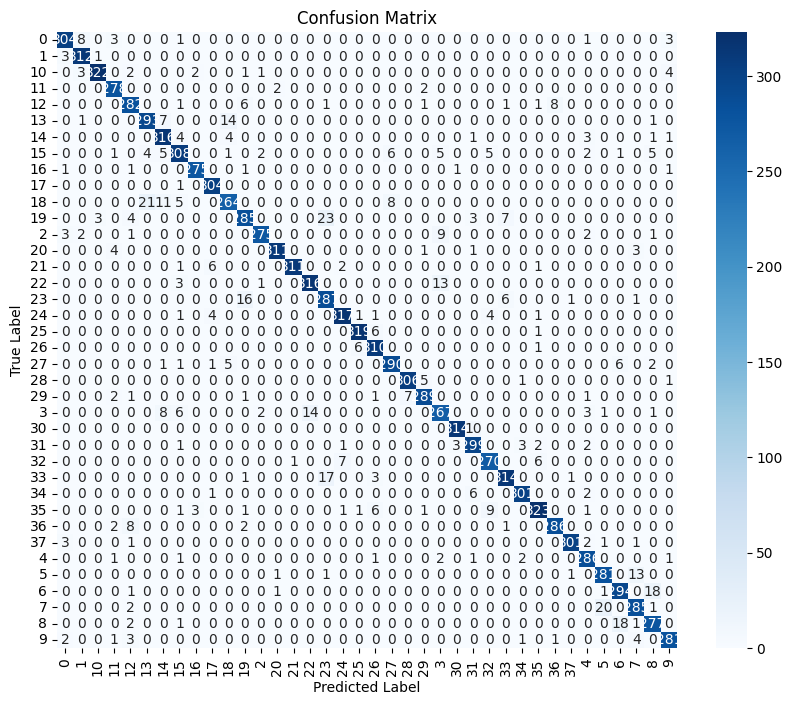

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       320
           1       0.96      0.99      0.97       316
          10       0.99      0.96      0.97       335
          11       0.95      0.99      0.97       282
          12       0.92      0.94      0.93       301
          13       0.92      0.93      0.92       316
          14       0.91      0.96      0.93       330
          15       0.92      0.89      0.90       345
          16       0.98      0.98      0.98       280
          17       0.96      1.00      0.98       305
          18       0.92      0.85      0.88       309
          19       0.91      0.88      0.89       325
           2       0.98      0.94      0.96       293
          20       0.99      0.97      0.98       320
          21       1.00      0.97      0.98       321
          22       0.96      0.95      0.95       333
          23       0.87      0.92      0.90       311
     

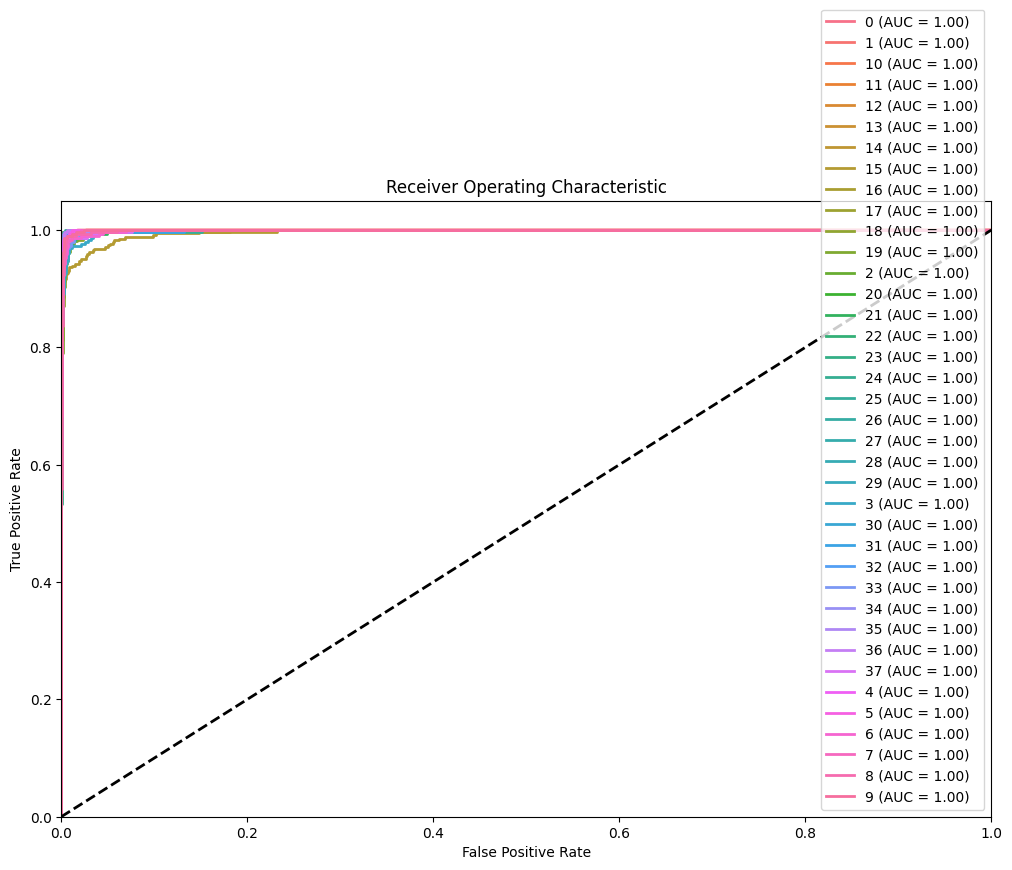

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, accuracy_score

# Recheck Data Generators
test_generator = test_datagen.flow_from_directory(
    '/content/data',  # Make sure this directory is correct
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Ensure no shuffling for consistency in predictions
)

# 1. Evaluate model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy from evaluate: {test_acc * 100:.2f}%')

# 2. Generate predictions on the test set
test_generator.reset()  # Ensure the generator is reset to the start
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

# 3. Compute accuracy manually
manual_acc = accuracy_score(y_true, y_pred)
print(f'Manual test accuracy: {manual_acc * 100:.2f}%')

# 4. Compute and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_plot_labels = list(test_generator.class_indices.keys())
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_plot_labels, yticklabels=cm_plot_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 5. Generate and print the classification report
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=cm_plot_labels))

# 6. Compute and plot the ROC AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(cm_plot_labels)):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(12, 8))
colors = sns.color_palette("husl", len(cm_plot_labels))
for i, color in zip(range(len(cm_plot_labels)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='{0} (AUC = {1:0.2f})'.format(cm_plot_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Found 11864 images belonging to 38 classes.
742/742 [==============================] - 30s 41ms/step - loss: 0.1779 - accuracy: 0.9485
Test accuracy from evaluate: 94.85%
742/742 [==============================] - 27s 37ms/step
Manual test accuracy: 94.85%


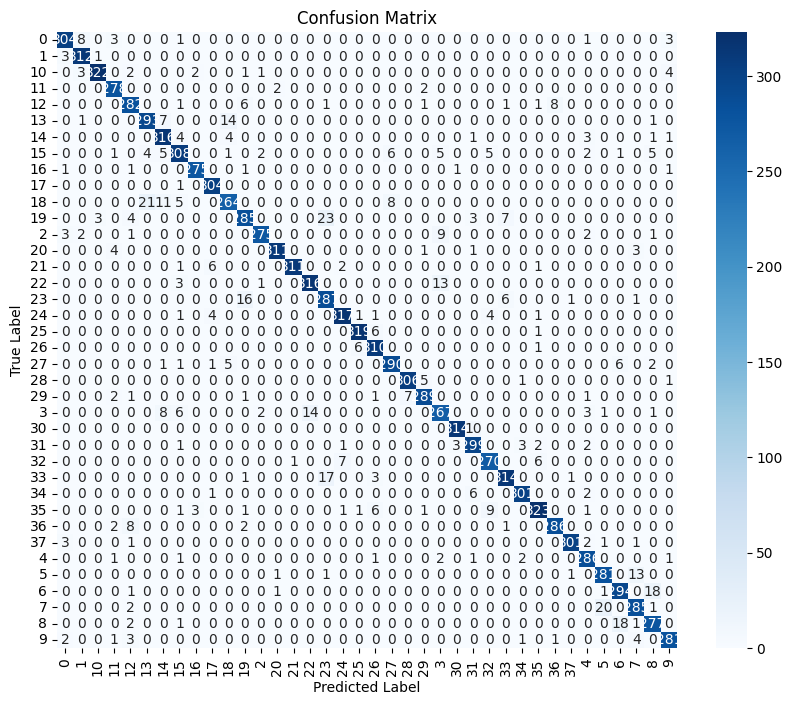

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       320
           1       0.96      0.99      0.97       316
          10       0.99      0.96      0.97       335
          11       0.95      0.99      0.97       282
          12       0.92      0.94      0.93       301
          13       0.92      0.93      0.92       316
          14       0.91      0.96      0.93       330
          15       0.92      0.89      0.90       345
          16       0.98      0.98      0.98       280
          17       0.96      1.00      0.98       305
          18       0.92      0.85      0.88       309
          19       0.91      0.88      0.89       325
           2       0.98      0.94      0.96       293
          20       0.99      0.97      0.98       320
          21       1.00      0.97      0.98       321
          22       0.96      0.95      0.95       333
          23       0.87      0.92      0.90       311
     

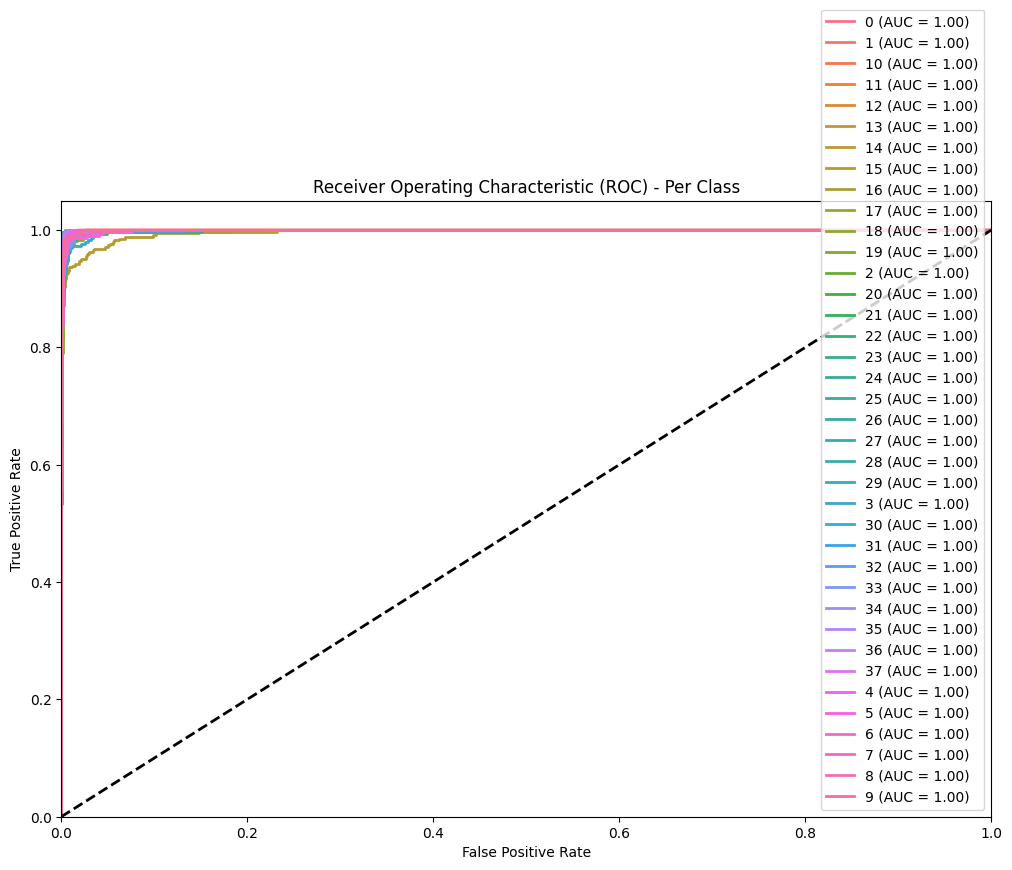

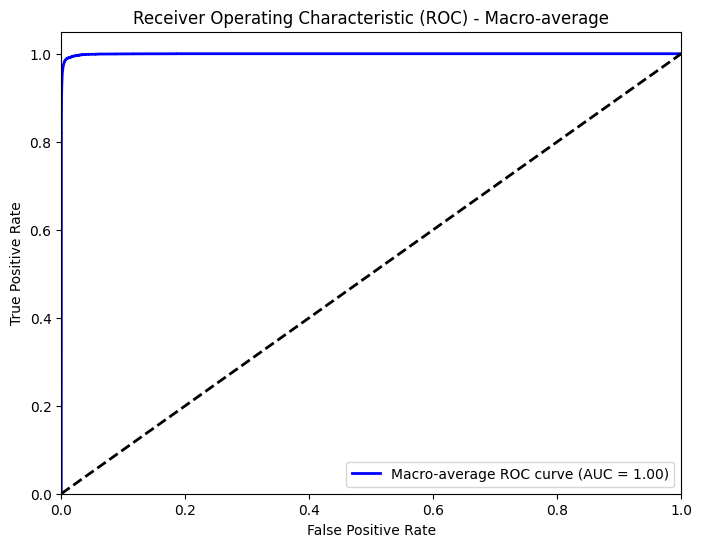

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize
from scipy import interp

# Recheck Data Generators
test_generator = test_datagen.flow_from_directory(
    '/content/data',  # Make sure this directory is correct
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Ensure no shuffling for consistency in predictions
)

# 1. Evaluate model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy from evaluate: {test_acc * 100:.2f}%')

# 2. Generate predictions on the test set
test_generator.reset()  # Ensure the generator is reset to the start
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

# 3. Compute accuracy manually
manual_acc = accuracy_score(y_true, y_pred)
print(f'Manual test accuracy: {manual_acc * 100:.2f}%')

# 4. Compute and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_plot_labels = list(test_generator.class_indices.keys())
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_plot_labels, yticklabels=cm_plot_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 5. Generate and print the classification report
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=cm_plot_labels))

# 6. Compute ROC AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(cm_plot_labels)):
    fpr[i], tpr[i], _ = roc_curve(label_binarize(y_true, classes=list(range(len(cm_plot_labels))))[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 7. Plot ROC curves for each class
plt.figure(figsize=(12, 8))
colors = sns.color_palette("husl", len(cm_plot_labels))
for i, color in zip(range(len(cm_plot_labels)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='{0} (AUC = {1:0.2f})'.format(cm_plot_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Per Class')
plt.legend(loc='lower right')
plt.show()

# 8. Compute macro-average ROC AUC
fpr_macro = dict()
tpr_macro = dict()
roc_auc_macro = dict()

# Compute macro-average ROC curve and ROC AUC
y_true_binary = label_binarize(y_true, classes=list(range(len(cm_plot_labels))))
fpr_macro["macro"], tpr_macro["macro"], _ = roc_curve(y_true_binary.ravel(), Y_pred.ravel())
roc_auc_macro["macro"] = auc(fpr_macro["macro"], tpr_macro["macro"])

# 9. Plot macro-average ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_macro["macro"], tpr_macro["macro"], color='blue',
         label=f'Macro-average ROC curve (AUC = {roc_auc_macro["macro"]:0.2f})', lw=2)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Macro-average')
plt.legend(loc='lower right')
plt.show()
